# Figures

In [1]:
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.min_rows = 10
pd.options.display.precision = 3
pd.options.display.float_format = "{:.3f}".format

import numpy as np

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={"float_kind": "{:.3f}".format})

import sys
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.colors import to_rgba
from scipy.spatial import procrustes
from scipy.spatial.distance import pdist

ROOT_PATH = (
    Path("__file__").resolve().parents[1]
)  # 0 for .py or unsaved notebooks and 1 for .ipynb
sys.path.append(ROOT_PATH.as_posix())

DATA_PATH = ROOT_PATH / "data"
RESULTS_PATH = ROOT_PATH / "results"
MODEL_PATH = ROOT_PATH / "analysis" / "models"
FIG_PATH = ROOT_PATH / "assets"

In [ ]:
df_pcm = pd.read_parquet(RESULTS_PATH / R"pcm_residuals\pcm_residuals.parquet")
df_lnrt = pd.read_parquet(RESULTS_PATH / R"lnrt_residuals\lnrt_residuals.parquet")
df_zinb = pd.read_parquet(RESULTS_PATH / R"zinb_residuals\zinb_residuals.parquet")
pcm_res = df_pcm.filter(regex="residuals").median()
lnrt_res = df_lnrt.filter(regex="residuals").median()
zinb_res = df_zinb.filter(regex="residuals").median()

df = pd.read_parquet(DATA_PATH / "COTS_2025_data.parquet")
df["min_resp_int"] = df.groupby("item_id")["response_selections"].transform("min")
df["process_counts"] = (
    df["exhibit_interactions"] + df["response_selections"] - df["min_resp_int"]
)

In [ ]:
process_counts = df["process_counts"]

counts = process_counts.value_counts().sort_index()
x = counts.index.values
y = counts.values

# fig, ax = plt.subplots(figsize=(8, 5))
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# plt.subplots_adjust(wspace=0.1)

ax = axs[0]

markerline, stemlines, baseline = ax.stem(
    x,
    y,
    linefmt="grey",
    markerfmt=".k",
    basefmt=" ",
    bottom=0,
)

# Highlight the zero value stem
if 0 in x:
    zero_idx = list(x).index(0)
    ax.plot(
        x[zero_idx],
        y[zero_idx],
        marker="o",
        markersize=14,
        markerfacecolor=to_rgba("red", 0.3),
        markeredgecolor=to_rgba("red", 0.9),
        markeredgewidth=2,
        label="Zero Count",
    )

plt.setp(
    markerline,
    marker="o",
    markersize=5,
    markerfacecolor=".7",
    markeredgecolor="black",
    markeredgewidth=1.5,
)

ax.annotate(
    "Zero Inflated",
    ha="left",
    va="top",
    fontsize=10,
    xy=(0, y[0]),
    xycoords="data",
    xytext=(10, 8000),
    textcoords="data",
    arrowprops=dict(
        arrowstyle="->",
        color="0",
        shrinkA=5,
        shrinkB=10,
        patchA=None,
        patchB=None,
        connectionstyle="arc3,rad=0.2",
        relpos=(0, 0.5),
    ),
)

ax.yaxis.set_visible(False)
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
sns.despine(ax=ax, left=True, offset=0, trim=True)
ax.set_title("Process Counts Distribution", fontsize=20)
ax.set_xlabel("Process Counts", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)

df_res = pd.DataFrame({"lnrt_res": lnrt_res.values, "pcm_res": pcm_res.values})
N_BINS = 15

df_res["rt_bin"] = pd.qcut(
    df_res["lnrt_res"], q=N_BINS, labels=False, duplicates="drop"
)
binned_data = (
    df_res.groupby("rt_bin").agg({"lnrt_res": "mean", "pcm_res": "mean"}).reset_index()
)

axs[1] = sns.regplot(
    x="lnrt_res",
    y="pcm_res",
    data=binned_data,
    ci=None,
    scatter_kws={"s": 100, "alpha": 0.8, "edgecolor": "black", "color": "w"},
    line_kws={"color": "firebrick", "linewidth": 2},
    # lowess=True,
    order=2,
    ax=axs[1],
)


axs[1].set_ylim(-0.03, 0.03)
axs[1].set_xlim(-1, 1)
axs[1].xaxis.set_major_locator(mtick.MaxNLocator(nbins=7))
axs[1].set_xticks(np.linspace(-1, 1, 5))
sns.despine(ax=axs[1], offset=dict(left=5, bottom=5), trim=True)

axs[1].set_xlabel("LNRT Binned Residuals", fontsize=16)
axs[1].set_ylabel("Average PCM Residuals", fontsize=16)
axs[1].set_title("Response Time and\nAccuracy Residuals", fontsize=20, pad=0)


df_res = pd.DataFrame({"zinb_res": zinb_res.values, "pcm_res": pcm_res.values})
N_BINS = 15

df_res["pcm_bin"] = pd.qcut(
    df_res["pcm_res"], q=N_BINS, labels=False, duplicates="drop"
)

binned_data = (
    df_res.groupby("pcm_bin").agg({"zinb_res": "mean", "pcm_res": "mean"}).reset_index()
)

axs[2] = sns.regplot(
    x="pcm_res",
    y="zinb_res",
    data=binned_data,
    ci=None,
    scatter_kws={"s": 100, "alpha": 0.8, "edgecolor": "black", "color": "w"},
    line_kws={"color": "firebrick", "linewidth": 2},
    # lowess=True,
    order=2,
    ax=axs[2],
)

axs[2].set_ylim(-0.3, 0.4)
axs[2].set_xlim(-1, 1.5)
sns.despine(ax=axs[2], offset=dict(left=5, bottom=5), trim=False)
axs[2].set_xlabel("PCM Binned Residuals", fontsize=16)
axs[2].set_ylabel("Average ZINB Residuals", fontsize=16)
axs[2].set_title("Process Counts and\nAccuracy Residuals", fontsize=20, pad=0)
fig.align_titles()
plt.savefig(
    FIG_PATH / "Descriptive_Motivation.svg", bbox_inches="tight", transparent=False
)
plt.show()

# plt.show()


In [2]:
def outlier_mask_by_distance(
    arr: np.ndarray, k: float = 3.0, use_median: bool = True
) -> np.ndarray:
    """
    Create boolean mask excluding outliers by Euclidean distance.

    Parameters
    ----------
    arr : np.ndarray
        2D array shape (n_items, n_dims).
    k : float, optional
        Multiplier for MAD cutoff (default 3.0).
    use_median : bool, optional
        Use median centroid if True, else mean.

    Returns
    -------
    np.ndarray
        Boolean mask (True = keep)
    """
    arr = np.asarray(arr, dtype=float)
    centroid = np.median(arr, axis=0) if use_median else np.mean(arr, axis=0)
    d = np.linalg.norm(arr - centroid, axis=1)
    med = np.median(d)
    mad = np.median(np.abs(d - med)) or 1.0
    thresh = med + k * mad
    return d <= thresh


def get_latent_locations(file_path, item_filter=False):
    # Validate Drop_Cloze items are filtered for non-process data
    idx_exclude = [7, 14]
    df = pd.read_parquet(file_path)

    zt_1 = df.median().filter(regex=r"zt_centered\[.*1\]$")
    zt_2 = df.median().filter(regex=r"zt_centered\[.*2\]$")
    z_loc = np.array([i for i in zip(zt_1, zt_2)])

    xi_1 = df.median().filter(regex=r"xi\[.*1\]$")
    xi_2 = df.median().filter(regex=r"xi\[.*2\]$")
    x_loc = np.array([i for i in zip(xi_1, xi_2)])
    mask = outlier_mask_by_distance(x_loc, k=3.0)
    x_loc = x_loc[mask]

    if item_filter:
        z_loc = np.delete(z_loc, idx_exclude, axis=0)

    return z_loc, x_loc


pcm_z_loc, pcm_x_loc = get_latent_locations(
    RESULTS_PATH / R"ls-pcm\ls-pcm_aligned.parquet", item_filter=True
)
lnrt_z_loc, lnrt_x_loc = get_latent_locations(
    RESULTS_PATH / R"ls-lnrt\ls-lnrt_aligned.parquet", item_filter=True
)
zinb_z_loc, zinb_x_loc = get_latent_locations(
    RESULTS_PATH / R"ls-zinb\ls-zinb_aligned.parquet"
)
unified_z_loc, unified_x_loc = get_latent_locations(
    RESULTS_PATH / R"ls-unified_pip\ls-unified_pip_aligned.parquet"
)
unified_sep_z_loc, unified_sep_x_loc = get_latent_locations(
    RESULTS_PATH
    / R"ls-unified_separate_gamma_pip\ls-unified_separate_gamma_pip_aligned.parquet"
)

In [ ]:
def compare_and_plot_spaces(
    separate_coords,
    unified_coords,
    model_name,
    ax,
    labels: list[str] | None = None,
    label_at: Literal["unified", "separate", "mid"] = "unified",
):
    """
    Performs Procrustes alignment, calculates comparison metrics, and generates
    a barbell plot comparing a separate latent space to the unified one.

    Args:
        separate_coords (np.array): Item coordinates from a modality-specific model.
        unified_coords (np.array): Item coordinates from the unified model (the target).
        model_name (str): The name of the separate model (e.g., "PCM").
        ax (matplotlib.axes.Axes): The axis object on which to draw the plot.
    """
    mtx1, mtx2_aligned, disparity = procrustes(unified_coords, separate_coords)

    dist_unified = pdist(mtx1)
    dist_separate_aligned = pdist(mtx2_aligned)
    dist_corr = np.corrcoef(dist_unified, dist_separate_aligned)[0, 1]

    # Unified model (the target configuration)
    ax.scatter(
        mtx1[:, 0],
        mtx1[:, 1],
        c="dodgerblue",
        s=120,
        label="Unified Model",
        zorder=5,
        edgecolors="black",
    )

    # Focal model (after alignment)
    ax.scatter(
        mtx2_aligned[:, 0],
        mtx2_aligned[:, 1],
        c="red",
        s=120,
        label=f"{model_name} Model",
        zorder=5,
        edgecolors="black",
    )

    # Draw connectors and place labels using offset in display (points).
    n = mtx1.shape[0]
    for i in range(n):
        x1, y1 = mtx1[i]
        x2, y2 = mtx2_aligned[i]
        ax.plot([x1, x2], [y1, y2], c="gray", linestyle="--", linewidth=1.5, zorder=0)

        lab = labels[i] if labels is not None and i < len(labels) else str(i + 1)

        if label_at == "unified":
            xy = (x1, y1)
        elif label_at == "separate":
            xy = (x2, y2)
        else:  # "mid"
            xy = ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

        # Use offset in points so position is consistent visually.
        ax.annotate(
            lab,
            xy,
            xytext=(6, 6),
            textcoords="offset points",
            ha="left",
            va="bottom",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.12", fc="white", alpha=0.7),
        )

    # Stats
    info_text = f"$\\Delta$: {disparity:.3f}\n$\\rho$: {dist_corr:.3f}"
    ax.text(
        0.98,
        0.2,
        info_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=dict(boxstyle="round,pad=0.5", fc="wheat", alpha=0.5),
    )
    
    ax.set_title(f"Unified Model vs. {model_name} Model", fontsize=16)
    ax.tick_params(
        axis="both", which="both", length=0, labelbottom=False, labelleft=False
    )
    ax.legend(facecolor="#ECEFF4", loc="lower right", fontsize=12)
    ax.set_ylim(-0.3, 0.4)
    ax.set_xlim(-0.2, 0.4)
    combined_loc = np.concatenate([mtx1, mtx2_aligned], axis=0)
    x_min, y_min = combined_loc.min(0).round(1) - 0.05
    x_max, y_max = combined_loc.max(0).round(1) + 0.05
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle=":")

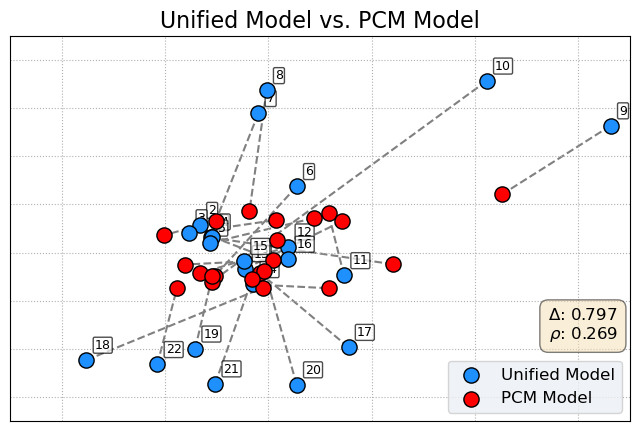

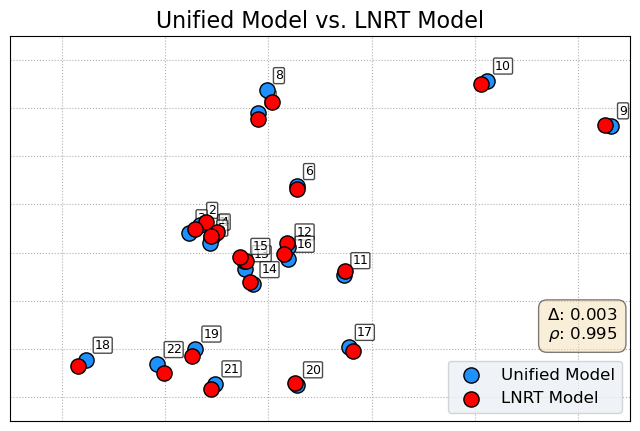

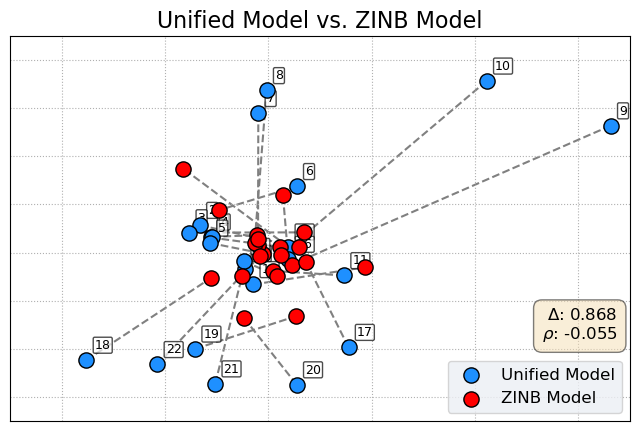

In [146]:
fig, ax = plt.subplots(figsize=(8, 5))
compare_and_plot_spaces(pcm_z_loc, unified_sep_z_loc, "PCM", ax=ax)
plt.savefig(
    FIG_PATH / "pcm_unified_separate.svg", bbox_inches="tight", transparent=False
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
compare_and_plot_spaces(lnrt_z_loc, unified_sep_z_loc, "LNRT", ax=ax)
plt.savefig(
    FIG_PATH / "lnrt_unified_separate.svg", bbox_inches="tight", transparent=False
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
compare_and_plot_spaces(zinb_z_loc, unified_sep_z_loc, "ZINB", ax=ax)
plt.savefig(
    FIG_PATH / "zinb_unified_separate.svg", bbox_inches="tight", transparent=False
)
plt.show()

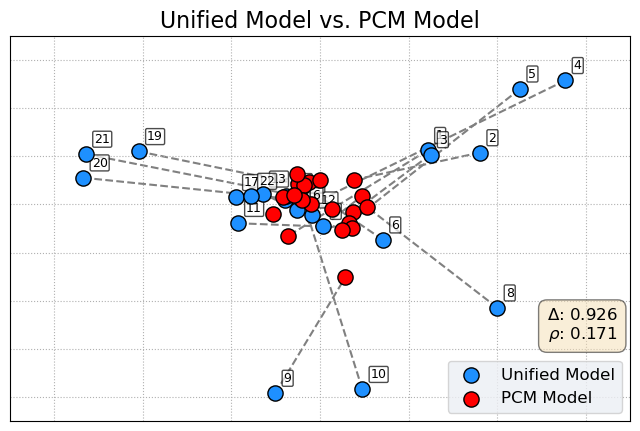

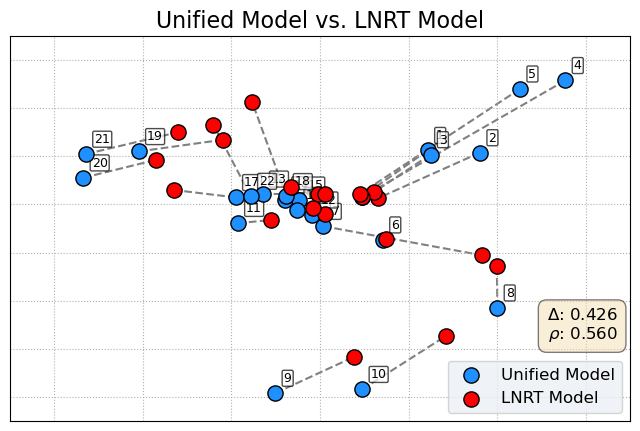

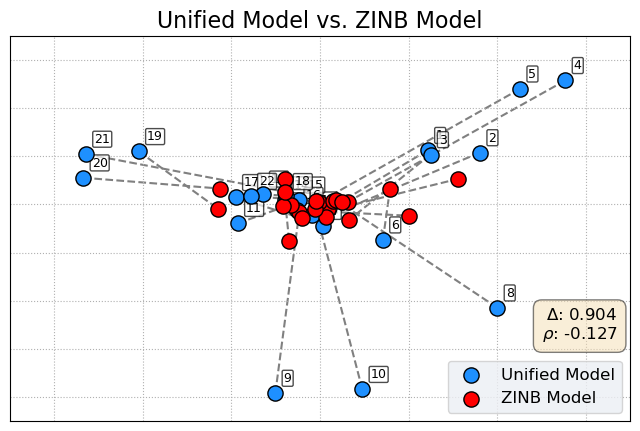

In [147]:
fig, ax = plt.subplots(figsize=(8, 5))
compare_and_plot_spaces(pcm_z_loc, unified_z_loc, "PCM", ax=ax)
plt.savefig(
    FIG_PATH / "pcm_unified_single.svg", bbox_inches="tight", transparent=False
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
compare_and_plot_spaces(lnrt_z_loc, unified_z_loc, "LNRT", ax=ax)
plt.savefig(
    FIG_PATH / "lnrt_unified_single.svg", bbox_inches="tight", transparent=False
)
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
compare_and_plot_spaces(zinb_z_loc, unified_z_loc, "ZINB", ax=ax)
plt.savefig(
    FIG_PATH / "zinb_unified_single.svg", bbox_inches="tight", transparent=False
)
plt.show()